In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as geopd
from shapely.geometry import Point
from ipyleaflet import Map, Marker, MarkerCluster

import hdbscan
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

Создаем объект DataFrame из файла статистики абонента

In [2]:
ab_stat = pd.read_excel('ab_stat.xlsx', index_col=False)
ab_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22149 entries, 0 to 22148
Data columns (total 21 columns):
Unnamed: 0    22149 non-null int64
DATE          22149 non-null datetime64[ns]
DURATION      22149 non-null float64
TYPE          22149 non-null object
DIRECTION     22149 non-null object
MSISDN_A      22149 non-null int64
IMSI_A        22149 non-null int64
IMEI_A        21095 non-null float64
MSISDN_B      2670 non-null float64
LAC_A         22149 non-null int64
CELLID_A      22149 non-null int64
AZIMUTH_A     22149 non-null int64
ADDRESS_A     22073 non-null object
ROAMING       22149 non-null object
LAC           22149 non-null int64
CELL          22149 non-null int64
ADDRESS       22149 non-null object
LON           22149 non-null float64
LAT           22149 non-null float64
AZIMUTH       21862 non-null float64
LOCATION      20644 non-null object
dtypes: datetime64[ns](1), float64(6), int64(8), object(6)
memory usage: 3.5+ MB


### Задача кластеризации мест пребования и вычисления вероятностей перехода между ними (Цепь Маркова)

Из файла статистики выбираем данные, относящиеся к перемещению абонента  
DATE - время  
LAT, LON - координаты БС  
LAC, CELL - идентификаторы БС
AZIMUTH - сектор обслуживания БС  
LOCATION - внешняя/внутренняя БС

In [3]:
lat_long = ab_stat[['DATE', 'LAT', 'LON', 'AZIMUTH', 'LOCATION', 'LAC', 'CELL']]
lat_long['LAC_CELL'] = lat_long.apply(lambda x: str(x.LAC) + '_' + str(x.CELL), axis=1)
lat_long = lat_long.drop(['LAC', 'CELL'], axis=1)
lat_long.head()

/Users/kosmosivanov/.conda/envs/TerVer/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DATE,LAT,LON,AZIMUTH,LOCATION,LAC_CELL
0,2018-05-03 12:46:52,56.28441,38.396787,200.0,outdoor,9021_63793
1,2018-05-03 13:46:52,56.28441,38.396787,200.0,outdoor,9021_63793
2,2018-05-03 14:46:52,56.28441,38.396787,200.0,outdoor,9021_63793
3,2018-05-09 11:04:52,56.28441,38.396787,200.0,outdoor,9021_63793
4,2018-05-09 19:04:52,56.28441,38.396787,200.0,outdoor,9021_63793


Создаем Серию из LAC_CELL и временным индексом для фильтрации редких БС

In [4]:
lat_long_index = lat_long[['DATE', 'LAC_CELL']]
lat_long_index.index = lat_long.DATE
lat_long_index = lat_long_index['LAC_CELL']
lat_long_index.head()

DATE
2018-05-03 12:46:52    9021_63793
2018-05-03 13:46:52    9021_63793
2018-05-03 14:46:52    9021_63793
2018-05-09 11:04:52    9021_63793
2018-05-09 19:04:52    9021_63793
Name: LAC_CELL, dtype: object

Фильтруем БС, встречающиеся более 1 раза

In [5]:
lat_long_index = lat_long_index[lat_long_index.map(lat_long_index.value_counts()) > 1]
lat_long_index.shape[0]

21925

Ресемплим серию по ежечастному интервалу, выбираем БС которая чаще всего встречается в каждом часе

In [6]:
r = lat_long_index.resample('H')
lat_long_index_1h = r.apply(lambda x: x.value_counts().index[0] 
                            if len(x.value_counts()) else None)
lat_long_index_1h.dropna(inplace=True)
lat_long_index_1h.shape[0]

5810

Объединяем отфильтрованные БС с исходным датафреймом с местами пребывания

In [7]:
lat_long_index_1h_df = pd.DataFrame(lat_long_index_1h).reset_index().merge(
                            lat_long[['LAC_CELL', 'LAT', 'LON', 'AZIMUTH', 'LOCATION']].drop_duplicates())
lat_long_index_1h_df.head()

,DATE,LAC_CELL,LAT,LON,AZIMUTH,LOCATION
0,2018-05-03 12:00:00,5036_197534212,56.288675,38.210756,60.0,outdoor
1,2018-05-03 13:00:00,9021_63793,56.284410,38.396787,200.0,outdoor
2,2018-05-09 11:00:00,9021_63793,56.284410,38.396787,200.0,outdoor
3,2018-05-09 19:00:00,9021_63793,56.284410,38.396787,200.0,outdoor
4,2018-05-09 20:00:00,9021_63793,56.284410,38.396787,200.0,outdoor


Фильтруем по уникальным точкам без дат, создаем объект GeoPandas по LAT LON координатам 

In [8]:
filtered_uniq_points = lat_long_index_1h_df.drop(['DATE'], axis=1).drop_duplicates()
geodf = geopd.GeoDataFrame(filtered_uniq_points, 
                           geometry=geopd.points_from_xy(filtered_uniq_points.LAT, 
                                                         filtered_uniq_points.LON))
geodf.head()

,LAC_CELL,LAT,LON,AZIMUTH,LOCATION,geometry
0,5036_197534212,56.288675,38.210756,60.0,outdoor,POINT (56.28867 38.21076)
1,9021_63793,56.284410,38.396787,200.0,outdoor,POINT (56.28441 38.39679)
64,9767_197921795,55.715389,37.665209,310.0,outdoor,POINT (55.71539 37.66521)
116,7797_27005,55.749575,37.623907,350.0,outdoor,POINT (55.74958 37.62391)
120,7752_8574,55.748552,37.529384,110.0,NaN,POINT (55.74855 37.52938)


In [9]:
geodf.shape[0]

519

БС могут быть расположены в одной точке, но обслуживать разные сектора (по AZIMUTH),  
при пространственной кластеризации они будут считаться за одни точки,  
поэтому необходимо сместить координаты на некторое расстояние (взято эмпирически 300 м) по направления AZIMUTH 

In [259]:
def my_translate(g):
    if g.LOCATION == 'outdoor':
        gr_meter = 111120 # метров в 1 градусе широты
        dist = 10 # сдвиг в метрах
        dist_gr_lat = dist / gr_meter # сдвиг по широте в градусах
        dist_gr_lon = dist_gr_lat * np.cos(g.geometry.x) # сдвиг по долготе в градусах
        
        g.geometry = Point(g.geometry.x + np.cos(np.deg2rad(g.AZIMUTH)) * dist_gr_lat,
                  g.geometry.y + np.sin(np.deg2rad(g.AZIMUTH)) * dist_gr_lon)
    return g

 
geodf_300 = geodf.apply(my_translate, axis=1)

geodf_300.LAT = geodf_300.geometry.x
geodf_300.LON = geodf_300.geometry.y

geodf_300.head()

,LAC_CELL,LAT,LON,AZIMUTH,LOCATION,geometry
0,5036_197534212,56.288720,38.210831,60.0,outdoor,POINT (56.28872 38.21083)
1,9021_63793,56.284325,38.396757,200.0,outdoor,POINT (56.28433 38.39676)
64,9767_197921795,55.715447,37.665163,310.0,outdoor,POINT (55.71545 37.66516)
116,7797_27005,55.749664,37.623896,350.0,outdoor,POINT (55.74966 37.62390)
120,7752_8574,55.748552,37.529384,110.0,NaN,POINT (55.74855 37.52938)


Параметры для Seaborn

In [260]:
plot_kwds = {'alpha' : 0.5, 's' : 30, 'linewidths':0, }

Отображение мест

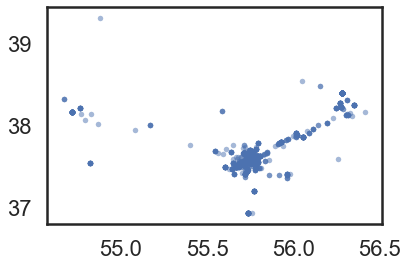

In [261]:
plt.scatter(lat_long_index_1h_df.LAT, lat_long_index_1h_df.LON, color='b', **plot_kwds)

Будет использован метод кластеризации HDBSCAN, метрика Хаверсайн,  
которая принимает координаты в радианах, нобходимо преобразование:

In [262]:
rad_uniq = np.deg2rad(geodf_300[['LAT', 'LON']])
rad_uniq.head()

,LAT,LON
0,0.982423,0.666905
1,0.982347,0.670150
64,0.972418,0.657381
116,0.973015,0.656661
120,0.972996,0.655011


Кластеризуем места пребывания, минимальный кластер ключает 5 элементов

In [263]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, metric='haversine', prediction_data=True)
clusterer.fit(rad_uniq)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='haversine', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=True)

Количество кластеров пребывания 

In [264]:
count_of_clusters = len(set(clusterer.labels_))
count_of_clusters

45

К датафрейму добавляем метки кластеров и меру близости

In [265]:
geodf_300['cluster'] = clusterer.labels_
geodf_300['probabilities'] = clusterer.probabilities_
geodf_300.head()

,LAC_CELL,LAT,LON,AZIMUTH,LOCATION,geometry,cluster,probabilities
0,5036_197534212,56.288720,38.210831,60.0,outdoor,POINT (56.28872 38.21083),7,1.0
1,9021_63793,56.284325,38.396757,200.0,outdoor,POINT (56.28433 38.39676),3,1.0
64,9767_197921795,55.715447,37.665163,310.0,outdoor,POINT (55.71545 37.66516),17,1.0
116,7797_27005,55.749664,37.623896,350.0,outdoor,POINT (55.74966 37.62390),34,1.0
120,7752_8574,55.748552,37.529384,110.0,NaN,POINT (55.74855 37.52938),-1,0.0


Создадим справочник по кластерам

In [266]:
cluster_info = geodf_300
cluster_info.index = geodf_300.cluster
cluster_info = cluster_info.sort_index()
cluster_info.drop(['cluster'], axis=1, inplace=True)
cluster_info

,LAC_CELL,LAT,LON,AZIMUTH,LOCATION,geometry,probabilities
cluster,,,,,,,
-1,9914_230622466,55.790450,37.531187,0.0,NaN,POINT (55.79045 37.53119),0.0
-1,9763_198247937,55.859873,37.395720,60.0,outdoor,POINT (55.85987 37.39572),0.0
-1,9736_15711489,55.756111,37.581944,180.0,NaN,POINT (55.75611 37.58194),0.0
-1,9734_197952012,55.683701,37.540291,90.0,outdoor,POINT (55.68370 37.54029),0.0
-1,9776_197906966,55.706224,37.516268,210.0,outdoor,POINT (55.70622 37.51627),0.0
...,...,...,...,...,...,...,...
43,9908_198815766,55.754349,37.636997,195.0,NaN,POINT (55.75435 37.63700),1.0
43,7797_47374,55.754387,37.636940,295.0,outdoor,POINT (55.75439 37.63694),1.0
43,9797_14233,55.754014,37.635434,250.0,outdoor,POINT (55.75401 37.63543),1.0


Создаем итоговый датафрейм, в котором индексы - временные ряды по часам, информация о месте, кластер,  
степень принадлежности к кластеру

In [267]:
points_1h_cluster = lat_long_index_1h_df.merge(geodf_300[['LAC_CELL', 'cluster', 'probabilities']])
points_1h_cluster.index = points_1h_cluster.DATE
points_1h_cluster.drop(['DATE'], axis=1, inplace=True)
points_1h_cluster = points_1h_cluster[points_1h_cluster.cluster >= 0]
points_1h_cluster.sort_index(inplace=True)
points_1h_cluster.head()

,LAC_CELL,LAT,LON,AZIMUTH,LOCATION,cluster,probabilities
DATE,,,,,,,
2018-05-03 12:00:00,5036_197534212,56.288675,38.210756,60.0,outdoor,7,1.0
2018-05-03 13:00:00,9021_63793,56.284410,38.396787,200.0,outdoor,3,1.0
2018-05-03 14:00:00,9767_197921795,55.715389,37.665209,310.0,outdoor,17,1.0
2018-05-03 15:00:00,9767_197921795,55.715389,37.665209,310.0,outdoor,17,1.0
2018-05-03 16:00:00,9767_197921795,55.715389,37.665209,310.0,outdoor,17,1.0


Построим матрицу вероятностей переходов между кластерами

In [268]:
p_markov = np.zeros((count_of_clusters-1, count_of_clusters-1))
before = -1
for i, row in points_1h_cluster.iterrows():
    if before == -1:
        before = row.cluster
    elif before != row.cluster:
        p_markov[before, row.cluster] += 1
        before = row.cluster
p_markov_1 = [row / row.sum() for row in p_markov]
p_markov_df = pd.DataFrame(p_markov_1)
p_markov_df.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.000000,0.0,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.055556,...,0.000000,0.055556,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.055556
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000
3,0.060606,0.0,0.030303,0.000000,0.060606,0.030303,0.121212,0.030303,0.030303,0.030303,...,0.030303,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.060606,0.000000,0.000000
4,0.023810,0.0,0.000000,0.083333,0.000000,0.083333,0.023810,0.142857,0.047619,0.011905,...,0.023810,0.000000,0.0,0.011905,0.0,0.02381,0.02381,0.023810,0.011905,0.000000


Предскажем будущие места пребывания, предположим, что абонент находится в Шереметьево (55.971821, 37.416570)

In [277]:
my_rad = np.deg2rad([55.971821, 37.416570])
cluster_now, _ = hdbscan.approximate_predict(clusterer, (my_rad,))
cluster_now = cluster_now[0]
print(f'Кооридана отнесена к кластеру № {cluster_now}')

Кооридана отнесена к кластеру № 2


In [278]:
points_now = cluster_info.loc[cluster_now].loc[cluster_info.loc[cluster_now].probabilities > 0.5]
m = Map(center=(55.75222, 37.61556), zoom=8)
m.add_layer(MarkerCluster(
    markers=[Marker(location=geolocation.coords[0]) 
             for geolocation in points_now.geometry])
    )
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Определение вероятных мест

In [283]:
places = round(p_markov_df.loc[cluster_now][p_markov_df.loc[cluster_now] > 0].sort_values(ascending=False), 2)
top_places = places.loc[places.values==places.max()]
print(f'Если абонент в настоящее время находится в зоне {cluster_now},\nто наиболее вероятeн переход в:\n{top_places}')

Если абонент в настоящее время находится в зоне 2,
то наиболее вероятeн переход в:
21    0.43
Name: 2, dtype: float64


Отрисовка кластеров

In [284]:
m = Map(center=(55.75222, 37.61556), zoom=8)
for cluster in top_places.index:
    m.add_layer(MarkerCluster(
        markers=[Marker(location=geolocation.coords[0]) 
                 for geolocation in 
                 cluster_info.loc[cluster].loc[cluster_info.loc[cluster].probabilities > 0.5].geometry])
        )
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [285]:
points_1h_cluster.to_csv('res.csv')

Распределение вероятностей по всем кластерам (топ 15)

In [286]:
res = (points_1h_cluster[['cluster', 'LAC_CELL']].groupby('cluster').count() / 
 points_1h_cluster.shape[0]).sort_values(by='LAC_CELL', ascending=False)[:15]
res

,LAC_CELL
cluster,
21,0.244386
32,0.168900
33,0.117758
26,0.052274
35,0.044537
4,0.040385
42,0.025099
41,0.024533
3,0.021702


In [287]:
m = Map(center=(55.75222, 37.61556), zoom=8)
for cluster in res.index:
    m.add_layer(MarkerCluster(
        markers=[Marker(location=geolocation.coords[0]) 
                 for geolocation in 
                 cluster_info.loc[cluster].loc[cluster_info.loc[cluster].probabilities > 0.5].geometry])
        )
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …